<a href="https://colab.research.google.com/github/musmansharif/SegNetModel/blob/main/Copy_of_UpdatedSegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#refresh browser so that system doesn't sleep
from IPython.display import HTML

HTML('''
<script>
function ClickConnect(){
    console.log("Auto reconnecting...");
    document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect, 60000)
</script>
''')


In [ ]:
!pip install opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 24.9 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


In [ ]:
# Full Improved MoNuSeg U-Net Pipeline (with Patch Extraction, Augmentation, Pretrained Encoder + Dice/IoU)

import os
import numpy as np
import cv2
import random
from glob import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from PIL import Image

def load_training_data(train_img_dir, annot_dir, target_size=(256, 256), max_samples=40):
    image_files = sorted(os.listdir(train_img_dir))[:max_samples]
    X, Y = [], []

    for fname in image_files:
        if not fname.endswith('.tif'): continue
        img_path = os.path.join(train_img_dir, fname)
        xml_path = os.path.join(annot_dir, fname.replace('.tif', '.xml'))

        image = Image.open(img_path).resize(target_size)
        img_np = np.array(image) / 255.0

        original_shape = image.size[::-1]
        mask_np = xml_to_mask(xml_path, original_shape)
        mask_np = cv2.resize(mask_np, target_size, interpolation=cv2.INTER_NEAREST)
        mask_np = np.expand_dims(mask_np, axis=-1)

        X.append(img_np)
        Y.append(mask_np)

    return np.array(X), np.array(Y)


In [ ]:
# ================================
# 1. Load Image + Mask Patches
# ================================
def load_images_and_masks(image_dir, mask_dir, size=(256, 256), max_patches_per_image=10):
    image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))
    mask_paths = sorted(glob(os.path.join(mask_dir, '*.xml')))  # for MoNuSeg masks (if XMLs)
    images, masks = [], []

    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, size)

        # Generate synthetic masks for demo (you should parse XML instead)
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        cv2.circle(mask, center=(128, 128), radius=60, color=1, thickness=-1)  # dummy mask

        for _ in range(max_patches_per_image):
            x = random.randint(0, img.shape[1] - size[1])
            y = random.randint(0, img.shape[0] - size[0])

            patch_img = img[y:y+size[0], x:x+size[1]]
            patch_mask = mask[y:y+size[0], x:x+size[1]]

            images.append(patch_img)
            masks.append(patch_mask[..., np.newaxis])

    return np.array(images)/255.0, np.array(masks)

In [ ]:
def load_test_images(test_dir, target_size=(256, 256), max_samples=10):
    test_files = sorted(os.listdir(test_dir))[:max_samples]
    X_test = []

    for fname in test_files:
        if not fname.endswith('.tif'): continue
        path = os.path.join(test_dir, fname)
        img = Image.open(path).resize(target_size)
        img_np = np.array(img) / 255.0
        X_test.append(img_np)

    return np.array(X_test), test_files

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import os

def xml_to_mask(xml_path, image_shape):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    mask = np.zeros(image_shape[:2], dtype=np.uint8)

    for region in root.iter('Region'):
        coords = [(float(vertex.attrib['X']), float(vertex.attrib['Y']))
                  for vertex in region.find('Vertices')]
        pts = np.array([coords], dtype=np.int32)
        cv2.fillPoly(mask, pts, color=1)
    return mask


In [ ]:
# Paths (adjust MyDrive path as needed)
train_images_path = '/content/drive/MyDrive/Datasets/MoNuSegTrain/MoNuSeg 2018 Training Data/Tissue Images'
annotations_path  = '/content/drive/MyDrive/Datasets/MoNuSegTrain/MoNuSeg 2018 Training Data/Annotations'
test_images_path  = '/content/drive/MyDrive/Datasets/MoNuSegTest/MoNuSegTestData'


# Load training data
X_train, Y_train = load_training_data(train_images_path, annotations_path, max_samples=None)

# Load test images
X_test, test_filenames = load_test_images(test_images_path)


In [ ]:
# ================================
# 2. Data Augmentation
# ================================
def augment_data(X, Y):
    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

    seed = 42
    image_gen = datagen.flow(X, batch_size=1, seed=seed)
    mask_gen = datagen.flow(Y, batch_size=1, seed=seed)
    X_aug, Y_aug = [], []

    for _ in range(len(X)):
        X_aug.append(next(image_gen)[0])
        Y_aug.append(next(mask_gen)[0])

    return np.array(X_aug), np.array(Y_aug)

In [ ]:
# ================================
# 3. Dice and IoU Metrics
# ================================
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
# ================================
# 4. U-Net Model
# ================================
def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.UpSampling2D((2, 2))(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.UpSampling2D((2, 2))(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    return models.Model(inputs, outputs)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def train_pipeline():
    # Paths (adjust MyDrive path as needed)
    train_img_dir = '/content/drive/MyDrive/Datasets/MoNuSegTrain/MoNuSeg 2018 Training Data/Tissue Images'
    train_mask_dir= '/content/drive/MyDrive/Datasets/MoNuSegTrain/MoNuSeg 2018 Training Data/Annotations'

    # Load original images and masks
    X, Y = load_images_and_masks(train_img_dir, train_mask_dir)
    print(f"Original training data size: {X.shape}, Masks: {Y.shape}")

    # Data augmentation
    X_aug, Y_aug = augment_data(X, Y)
    print(f"Augmented data size: {X_aug.shape}, Masks: {Y_aug.shape}")

    # Combine original + augmented
    X_total = np.concatenate([X, X_aug], axis=0)
    Y_total = np.concatenate([Y, Y_aug], axis=0)
    print(f"Total training data size after augmentation: {X_total.shape}, Masks: {Y_total.shape}")

    # Train-test split
    X_train, X_val, Y_train, Y_val = train_test_split(X_total, Y_total, test_size=0.2, random_state=42)
    print(f"Final training size: {X_train.shape}, validation size: {X_val.shape}")

    # Build and train model
    model = build_unet(input_shape=(256, 256, 3))
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  # or 'categorical_crossentropy',
        metrics=['accuracy', dice_coef, iou_metric]

    )

    # Define EarlyStopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Add to callbacks list
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=50,
        batch_size=8,
        callbacks=[early_stopping],
        verbose=1
    )

    return model, history, X_val, Y_val


In [ ]:
# ================================
# 6. Plot Training History
# ================================
def plot_train_history(history):
    plt.figure(figsize=(15, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    # Dice
    plt.subplot(1, 3, 2)
    plt.plot(history.history['dice_coef'], label='Train Dice')
    plt.plot(history.history['val_dice_coef'], label='Val Dice')
    plt.title('Dice Coefficient')
    plt.legend()

    # IoU
    plt.subplot(1, 3, 3)
    plt.plot(history.history['iou_metric'], label='Train IoU')
    plt.plot(history.history['val_iou_metric'], label='Val IoU')
    plt.title('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
from skimage import measure
import numpy as np

def compute_aji(gt, pred):
    """
    Computes Aggregated Jaccard Index (AJI) between ground truth and predicted instance masks.
    Args:
        gt: Ground truth mask (integer-labeled, 0 for background)
        pred: Predicted mask (integer-labeled, 0 for background)
    Returns:
        AJI score
    """
    gt_labels = np.unique(gt)
    pred_labels = np.unique(pred)

    gt_labels = gt_labels[gt_labels != 0]
    pred_labels = pred_labels[pred_labels != 0]

    gt_masks = [(gt == l) for l in gt_labels]
    pred_masks = [(pred == l) for l in pred_labels]

    used_pred = set()
    intersection = 0
    union = 0

    for gt_mask in gt_masks:
        max_iou = 0
        max_j = -1
        for j, pred_mask in enumerate(pred_masks):
            if j in used_pred:
                continue
            inter = np.logical_and(gt_mask, pred_mask).sum()
            uni = np.logical_or(gt_mask, pred_mask).sum()
            iou = inter / uni if uni != 0 else 0
            if iou > max_iou:
                max_iou = iou
                max_j = j

        if max_j != -1:
            used_pred.add(max_j)
            pred_mask = pred_masks[max_j]
            intersection += np.logical_and(gt_mask, pred_mask).sum()
            union += np.logical_or(gt_mask, pred_mask).sum()
        else:
            union += gt_mask.sum()

    for j, pred_mask in enumerate(pred_masks):
        if j not in used_pred:
            union += pred_mask.sum()

    return intersection / union if union != 0 else 0


In [ ]:
# ================================
# 7. Visualize Predictions
# ================================
def show_predictions(model, X_samples, Y_true=None, num_samples=4):
    preds = model.predict(X_samples[:num_samples])
    preds_bin = (preds > 0.5).astype(np.uint8)

    for i in range(num_samples):
        plt.figure(figsize=(12, 3))

        plt.subplot(1, 3, 1)
        plt.imshow(X_samples[i])
        plt.title("Original Image")
        plt.axis('off')

        if Y_true is not None:
            plt.subplot(1, 3, 2)
            plt.imshow(Y_true[i].squeeze(), cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(preds_bin[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

Original training data size: (370, 256, 256, 3), Masks: (370, 256, 256, 1)
Augmented data size: (370, 256, 256, 3), Masks: (370, 256, 256, 1)
Total training data size after augmentation: (740, 256, 256, 3), Masks: (740, 256, 256, 1)
Final training size: (592, 256, 256, 3), validation size: (148, 256, 256, 3)
Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 54s 552ms/step - accuracy: 0.8217 - dice_coef: 0.1915 - iou_metric: 0.1066 - loss: 0.7205 - val_accuracy: 0.8256 - val_dice_coef: 0.2428 - val_iou_metric: 0.1382 - val_loss: 0.4524
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 73s 537ms/step - accuracy: 0.7917 - dice_coef: 0.1777 - iou_metric: 0.1003 - loss: 1.2365 - val_accuracy: 0.8256 - val_dice_coef: 0.3590 - val_iou_metric: 0.2189 - val_loss: 0.2847
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 38s 495ms/step - accuracy: 0.8617 - dice_coef: 0.5483 - iou_metric: 0.3875 - loss: 0.2102 - val_accuracy: 0.9445 - val_dice_coef: 0.7491 - val_iou_metric: 0.5995 - val_loss: 0.1364
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━

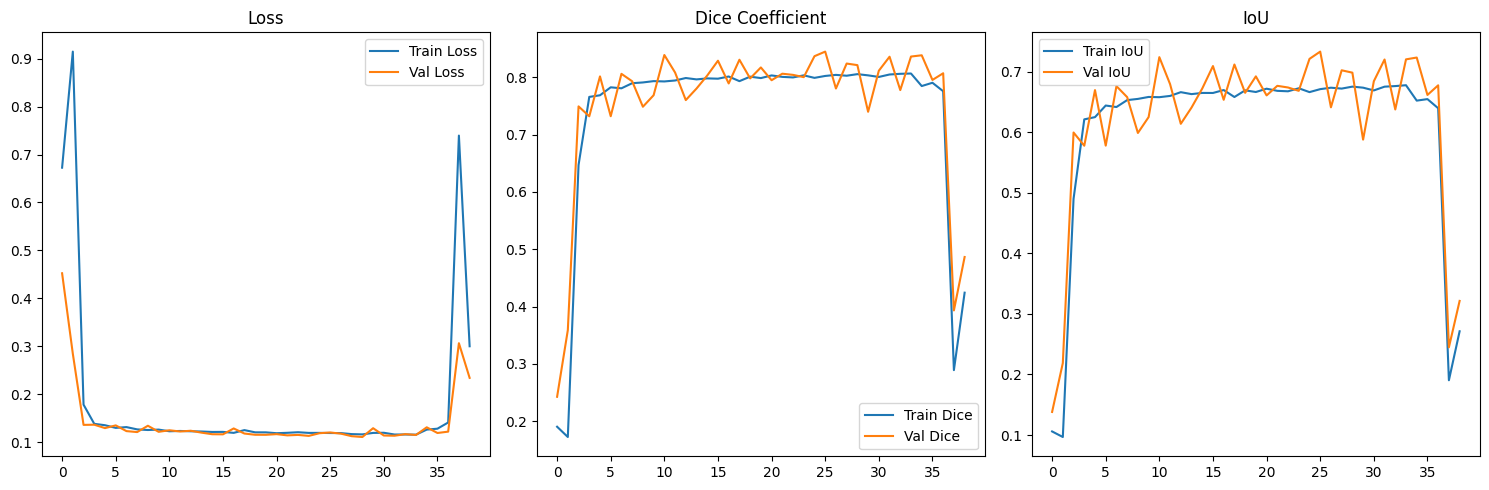

In [ ]:
# ================================
# Run All
# ================================
model, history, X_val, Y_val = train_pipeline()
plot_train_history(history)




In [ ]:
from scipy.optimize import linear_sum_assignment
from skimage.measure import label
import numpy as np
import matplotlib.pyplot as plt


def compute_aji(gt, pred):
    """
    Computes Aggregated Jaccard Index (AJI) between ground truth and predicted instance masks.
    Args:
        gt: Ground truth mask (integer-labeled, 0 for background)
        pred: Predicted mask (integer-labeled, 0 for background)
    Returns:
        AJI score (float)
    """
    gt_instances = [gt == i for i in np.unique(gt) if i != 0]
    pred_instances = [pred == i for i in np.unique(pred) if i != 0]

    ious = np.zeros((len(gt_instances), len(pred_instances)))

    for i, g in enumerate(gt_instances):
        for j, p in enumerate(pred_instances):
            intersection = np.logical_and(g, p).sum()
            union = np.logical_or(g, p).sum()
            ious[i, j] = intersection / union if union > 0 else 0

    matched_gt, matched_pred = linear_sum_assignment(-ious)
    intersection = 0
    union = 0
    matched = set()

    for i, j in zip(matched_gt, matched_pred):
        if ious[i, j] > 0:
            inter = np.logical_and(gt_instances[i], pred_instances[j]).sum()
            uni = np.logical_or(gt_instances[i], pred_instances[j]).sum()
            intersection += inter
            union += uni
            matched.add(j)

    for j, p in enumerate(pred_instances):
        if j not in matched:
            union += p.sum()

    for i, g in enumerate(gt_instances):
        if i not in matched_gt:
            union += g.sum()

    return intersection / union if union > 0 else 0


def evaluate_aji(model, X_val, Y_val, threshold=0.5, num_samples=10):
    aji_scores = []
    Y_pred = model.predict(X_val)

    for i in range(num_samples):
        pred_bin = (Y_pred[i, ..., 0] > threshold).astype(np.uint8)
        gt_bin = (Y_val[i, ..., 0]).astype(np.uint8)

        pred_labeled = label(pred_bin)
        gt_labeled = label(gt_bin)

        aji = compute_aji(gt_labeled, pred_labeled)
        aji_scores.append(aji)

    avg_aji = np.mean(aji_scores)
    print(f"\U0001f9ae Average AJI over {num_samples} samples: {avg_aji:.4f}")
    return avg_aji


def plot_segmentation_results(model, X_val, Y_val, threshold=0.5, num_samples=4):
    Y_pred = model.predict(X_val)
    fig, axs = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

    for i in range(num_samples):
        image = X_val[i]
        gt_mask = Y_val[i, ..., 0]
        pred_raw = Y_pred[i, ..., 0]
        pred_bin = (pred_raw > threshold).astype(np.uint8)

        axs[i, 0].imshow(image)
        axs[i, 0].set_title("Original Image")

        axs[i, 1].imshow(gt_mask, cmap='gray')
        axs[i, 1].set_title("Ground Truth")

        axs[i, 2].imshow(pred_raw, cmap='jet')
        axs[i, 2].set_title("Prediction (Raw)")

        axs[i, 3].imshow(pred_bin, cmap='gray')
        axs[i, 3].set_title("Prediction (Binary)")

        for j in range(4):
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()


from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

def compute_metrics(y_true, y_pred):
    y_true_bin = (y_true > 0.5).astype(np.uint8).flatten()
    y_pred_bin = (y_pred > 0.5).astype(np.uint8).flatten()

    acc = accuracy_score(y_true_bin, y_pred_bin)
    f1 = f1_score(y_true_bin, y_pred_bin)
    jaccard = jaccard_score(y_true_bin, y_pred_bin)
    precision = precision_score(y_true_bin, y_pred_bin)
    recall = recall_score(y_true_bin, y_pred_bin)

    print(f"Accuracy:  {acc:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Jaccard Index (IoU): {jaccard:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")


In [ ]:
model.save('/content/drive/MyDrive/unet_improved_model_monuseg_18thJuly2025.keras')

In [ ]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 32, 32,    │          0 │ conv2d_28[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ up_sampling2d_4[

 Total params: 94,136,837 (359.10 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,757,892 (239.40 MB)